In [1]:
!pip install safetensors
from safetensors.torch import load_file
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch
from PIL import Image

# Model & Processor
model_name = "/content/config (4).json"
processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b3")
model_weights = load_file("/content/model (1).safetensors")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
    config=model_name)
model.load_state_dict(model_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inference
model.eval()
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b3 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [2]:
# Demo
image = Image.open("/content/0506235_sc-202337.jpg").convert("RGB").resize((512, 512))  # 예시 이미지


inputs = processor(images=image, return_tensors="pt").to(device)


with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

print(f"logit shape : {logits.shape}")
predictions = torch.argmax(logits, dim=1).squeeze(0)
print(f"After prediction and dimension squeezing, segmentation map shape: {predictions.shape}")

logit shape : torch.Size([1, 2, 128, 128])
after prediction and squeezing, segmap shape: torch.Size([128, 128])


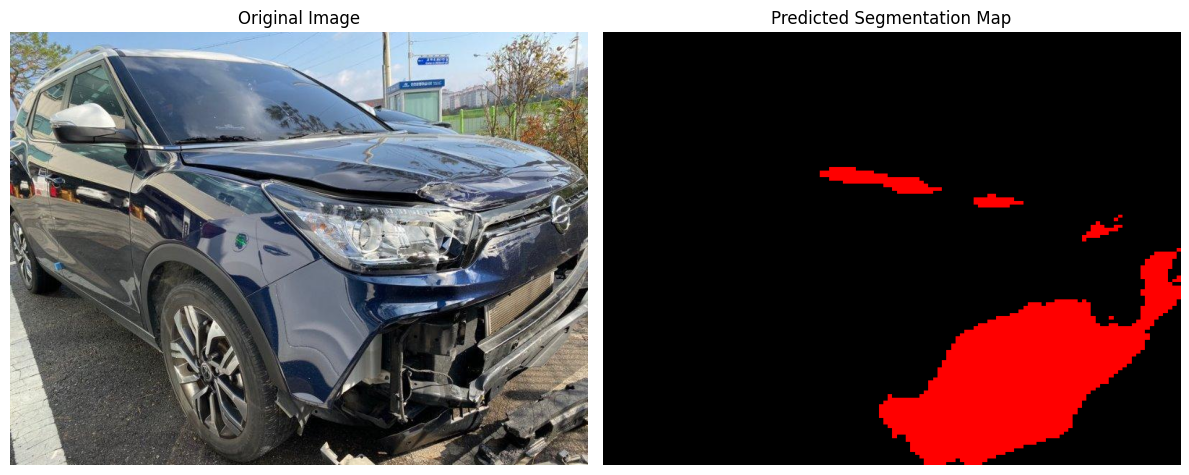

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

colors = [
    [0, 0, 0],      # Background
    [255, 0, 0]     # Damaged
]

image_path = "/content/0508547_as-0080366.jpg"  # Test pic 1

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictions = predictions.cpu().numpy()

# Convert Segmentation Map -> Backgroun to Black and Damaged part to Red
colored_map = np.zeros((predictions.shape[0], predictions.shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(colors):
    colored_map[predictions == class_id] = color

colored_map_resized = cv2.resize(colored_map, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(colored_map_resized)
plt.title("Predicted Segmentation Map")
plt.axis("off")

plt.tight_layout()
plt.show()